# FEEMS Demonstration

First load the necessary python packages and json data for components and configuration

In [1]:
import json
import numpy as np
import pandas as pd
from feems.components_model import Engine, ElectricMachine, Genset
from feems.components_model.component_electric import SerialSystemElectric, ElectricComponent
from feems.system_model import ElectricPowerSystem, IntegrationMethod
from feems.types_for_feems import TypePower, TypeComponent
from utils import get_type_component, get_component_configuration_data, \
    get_component_data_from_name, get_configured_component_from_name, \
    create_components_for_an_electric_system
import matplotlib.pyplot as plt

In [2]:
component_data, configuration_data = get_component_configuration_data()
print("******* Component data *******")
component_data

******* Component data *******


[{'type': 'AUXILIARY_ENGINE',
  'name': 'Auxiliary engine 700',
  'rated_power': 700,
  'rated_speed': 1500,
  'bsfc_curve': [[0.25, 0.5, 0.75, 1.0], [280.0, 220.0, 200.0, 210.0]]},
 {'type': 'AUXILIARY_ENGINE',
  'name': 'Auxiliary engine 1000',
  'rated_power': 1000,
  'rated_speed': 1500,
  'bsfc_curve': [[0.25, 0.5, 0.75, 0.1], [250.0, 200.0, 180.0, 195.0]]},
 {'type': 'GENERATOR',
  'name': 'Generator A',
  'rated_power': 665,
  'rated_speed': 1500,
  'eff_curve': [[1.0, 0.75, 0.5, 0.25], [0.95, 0.94, 0.92, 0.88]]},
 {'type': 'GENERATOR',
  'name': 'Generator B',
  'rated_power': 950,
  'rated_speed': 1500,
  'eff_curve': [[1.0, 0.75, 0.5, 0.25], [0.95, 0.94, 0.92, 0.88]]},
 {'type': 'ELECTRIC_MOTOR',
  'name': 'Electric Motor A',
  'rated_power': 800,
  'rated_speed': 1200,
  'eff_curve': [[1.0, 0.75, 0.5, 0.25], [0.95, 0.96, 0.91, 0.86]]},
 {'type': 'ELECTRIC_MOTOR',
  'name': 'Electric Motor B',
  'rated_power': 600,
  'rated_speed': 1200,
  'eff_curve': [[1.0, 0.75, 0.5, 0.25]

In [3]:
print("******* Configuration data *******")
configuration_data

******* Configuration data *******


[{'name': 'Aux engine 1',
  'component': 'Auxiliary engine 700',
  'switchboard_id': 1,
  'shaftline_id': None,
  'connected_to': 'Generator 1'},
 {'name': 'Aux engine 2',
  'component': 'Auxiliary engine 1000',
  'switchboard_id': 2,
  'shaftline_id': None,
  'connected_to': 'Generator 2'},
 {'name': 'Generator 1',
  'component': 'Generator A',
  'switchboard_id': 1,
  'shaftline_id': None,
  'connected_to': 'switchboard'},
 {'name': 'Generator 2',
  'component': 'Generator B',
  'switchboard_id': 2,
  'shaftline_id': None,
  'connected_to': 'switchboard'},
 {'name': 'Thruster motor 1',
  'component': 'Electric Motor A',
  'switchboard_id': 1,
  'shaftline_id': None,
  'connected_to': 'Inverter 1'},
 {'name': 'Thruster motor 2',
  'component': 'Electric Motor B',
  'switchboard_id': 2,
  'shaftline_id': None,
  'connected_to': 'Inverter 2'},
 {'name': 'Inverter 1',
  'component': 'Inverter',
  'switchboard_id': 1,
  'shaftline_id': None,
  'connected_to': 'Rectifier 1'},
 {'name': 'In

## Example 1: Create an atomic component

In [4]:
engine_component = get_configured_component_from_name('Aux engine 1', configuration_data)
engine_component_data = get_component_data_from_name(engine_component['component'], component_data)
aux_engine_1 = Engine(
    type_=get_type_component(engine_component_data['type']),
    name=engine_component['name'],
    rated_power=engine_component_data['rated_power'],
    rated_speed=engine_component_data['rated_speed'],
    bsfc_curve=np.asarray(engine_component_data['bsfc_curve']).transpose()
)
aux_engine_1

### Calculate the fuel consumption for a given power load

In [5]:
power_output = 450.0

engine_run_points = \
    aux_engine_1.get_engine_run_point_from_power_out_kw(power_output)

columns = ["Power [kW]", "Fuel consumption [kg/s]", "Load [%]", "BSFC [g/kWh]"]
columns_to_print = [column + '\t' for column in columns]
fuel_consumption = engine_run_points.fuel_flow_rate_kg_per_s.fuels[0].mass_or_mass_fraction
perc_load = engine_run_points.load_ratio * 100
bsfc = engine_run_points.bsfc_g_per_kWh
print(''.join(columns_to_print))
print(f"{power_output:3.2f}\t\t{fuel_consumption:5.5f}\t\t\t{perc_load:3.1f}\t\t{bsfc:3.1f}")

Power [kW]	Fuel consumption [kg/s]	Load [%]	BSFC [g/kWh]	
450.00		0.02559			64.3		204.7


### Calculate the fuel consumptions by setting the power outputs

In [6]:
power_output = np.arange(start=0, stop=710, step=50)
aux_engine_1.power_output = power_output

engine_run_points = \
    aux_engine_1.get_engine_run_point_from_power_out_kw()
fuel_consumption = engine_run_points.fuel_flow_rate_kg_per_s.fuels[0].mass_or_mass_fraction
perc_load = engine_run_points.load_ratio * 100
bsfc = engine_run_points.bsfc_g_per_kWh
data = np.array([fuel_consumption, perc_load * 100, bsfc]).transpose()
df = pd.DataFrame(data, index=power_output, columns=columns[1:])
print(df)

     Fuel consumption [kg/s]      Load [%]  BSFC [g/kWh]
0                   0.000000      0.000000    360.000000
50                  0.004703    714.285714    338.600583
100                 0.008759   1428.571429    315.335277
150                 0.012150   2142.857143    291.603499
200                 0.014934   2857.142857    268.804665
250                 0.017246   3571.428571    248.338192
300                 0.019300   4285.714286    231.603499
350                 0.021389   5000.000000    220.000000
400                 0.023518   5714.285714    211.661808
450                 0.025590   6428.571429    204.723032
500                 0.027859   7142.857143    200.583090
550                 0.030573   7857.142857    200.116618
600                 0.033552   8571.428571    201.311953
650                 0.036901   9285.714286    204.373178
700                 0.040833  10000.000000    210.000000


Plot the fuel consumption curve

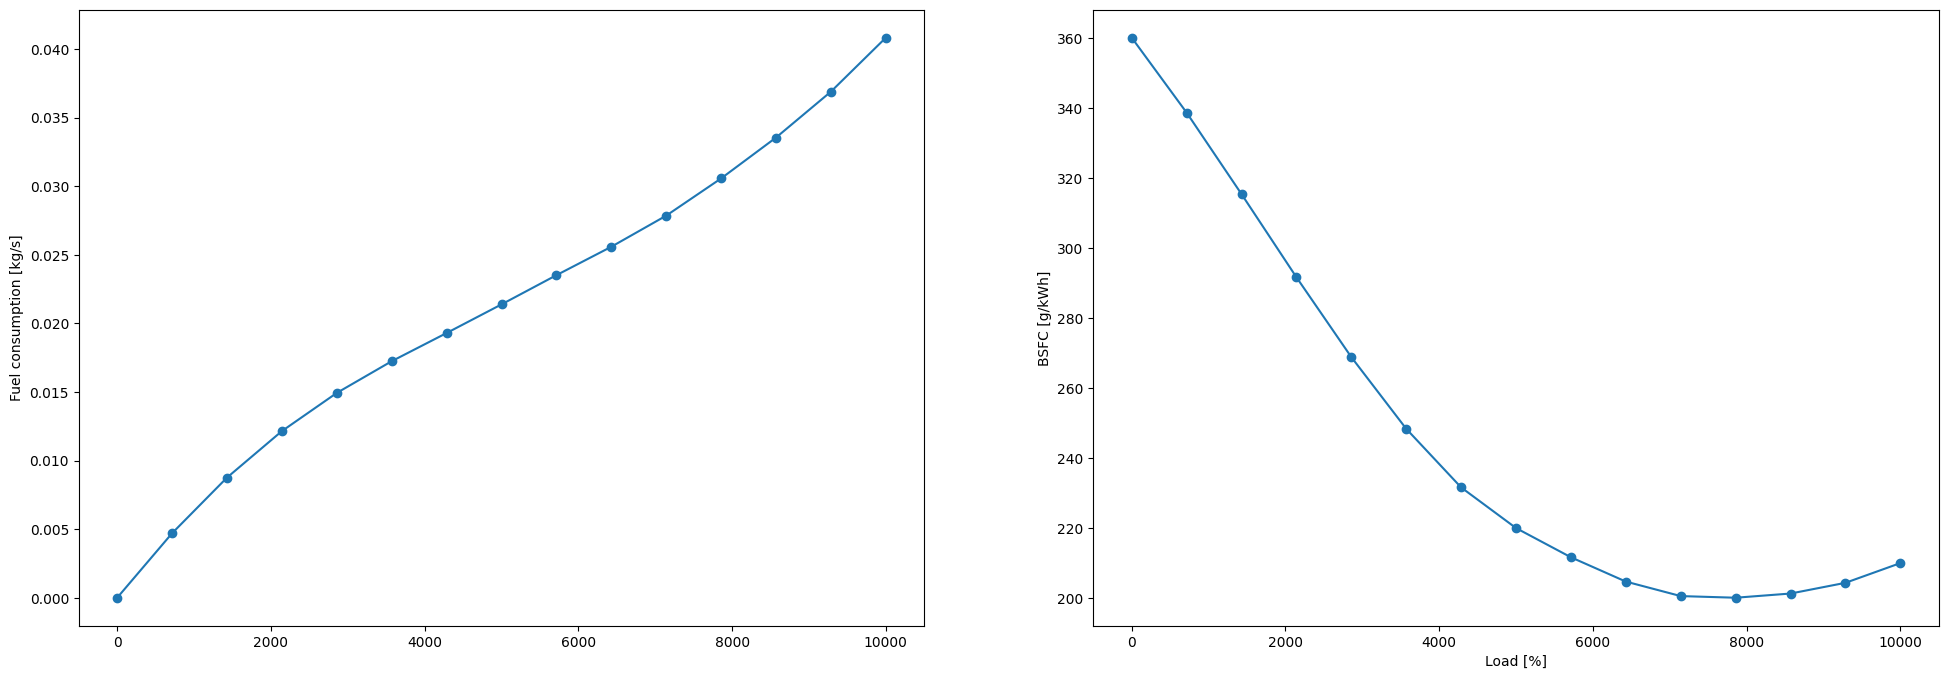

In [7]:
plt.figure(figsize=[24, 8])
plt.subplot(1,2,1)
plt.plot(df[columns[2]], df[columns[1]], 'o-')
plt.ylabel(columns[1])
plt.subplot(1,2,2)
plt.plot(df[columns[2]], df[columns[3]], 'o-')
plt.ylabel(columns[3])
plt.xlabel(columns[2])

plt.show()

## Example 2: Create a serial component
We are going to create a generator 1 component and make a serial component together with the
auxiliary engine created before. First, we create a generator component.

In [8]:
generator_component = get_configured_component_from_name('Generator 1', configuration_data)
generator_data = get_component_data_from_name(generator_component['component'], component_data)

generator_1 = ElectricMachine(
    type_=generator_data['type'],
    name=generator_component['name'],
    rated_power=generator_data['rated_power'],
    rated_speed=generator_data['rated_speed'],
    power_type=TypePower.POWER_SOURCE,
    switchboard_id=generator_component['switchboard_id'],
    eff_curve=np.asarray(generator_data['eff_curve']).transpose()
)
generator_1

Now, we can create a genset component as a serial component.

In [9]:
genset_1 = Genset(
    name="Genset 1",
    aux_engine=aux_engine_1,
    generator=generator_1
)
genset_1

We will calculate the fuel consumption of the genset from the power output of the genset in two ways.
First, we do the calculation using the separate components. Then we compare the result with the calculation
using the genset component.

First, we generate a random power series.

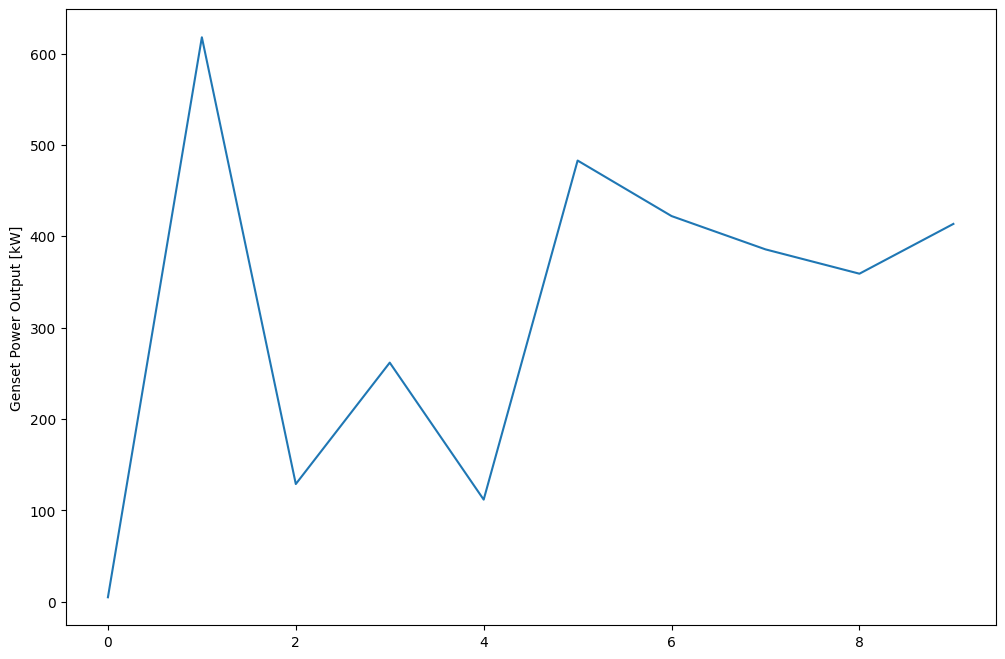

In [10]:
power_output = genset_1.rated_power * np.random.random(10)
plt.figure(figsize=[12, 8])
plt.plot(power_output)
plt.ylabel('Genset Power Output [kW]')

plt.show()

### Fuel calculation using the components separately
First we calculate the shaft power (power input) of the generator from the power output

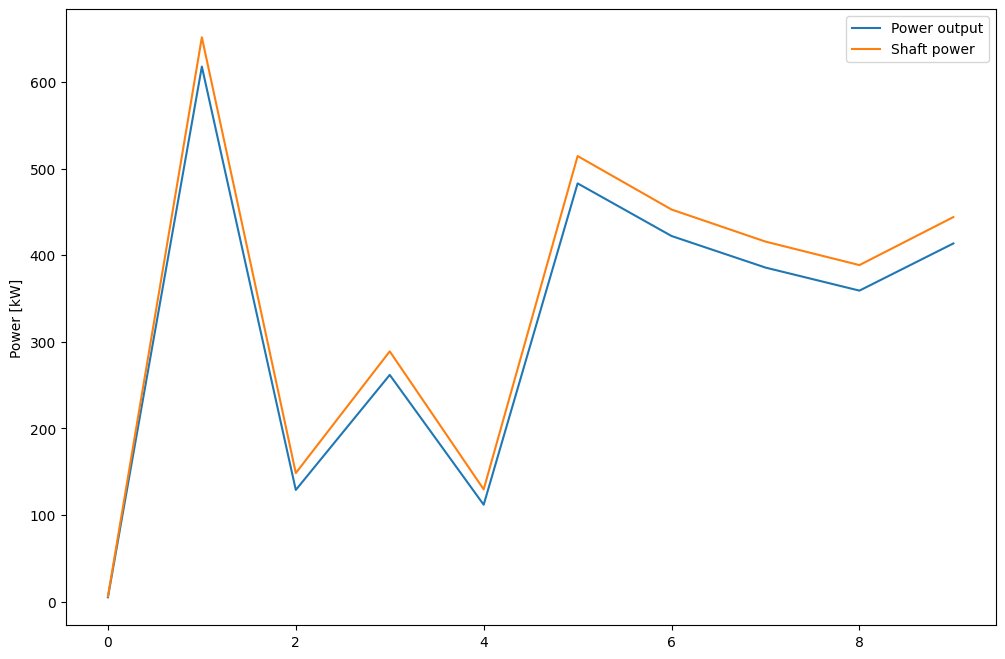

In [11]:
generator_1.set_power_input_from_output(power_output)
plt.figure(figsize=[12, 8])
plt.plot(power_output)
plt.plot(generator_1.power_input)
plt.ylabel('Power [kW]')
plt.legend(['Power output', 'Shaft power'])

plt.show()

Now we can calculate the fuel consumption for the shaft power

In [12]:
aux_engine_1.power_output = generator_1.power_input
engine_run_points = aux_engine_1.get_engine_run_point_from_power_out_kw()
fuel_consumption_ref = engine_run_points.fuel_flow_rate_kg_per_s.fuels[0].mass_or_mass_fraction
perc_load_ref = engine_run_points.load_ratio * 100
bsfc_ref = engine_run_points.bsfc_g_per_kWh
data = np.array([fuel_consumption_ref, perc_load_ref, bsfc_ref]).transpose()
df_ref = pd.DataFrame(data, index=power_output, columns=columns[1:])
print(df_ref)

            Fuel consumption [kg/s]   Load [%]  BSFC [g/kWh]
4.883355                   0.000586   0.842299    357.619243
617.774585                 0.037017  93.086572    204.510290
128.820819                 0.012048  21.190762    292.386350
261.688525                 0.018852  41.268438    234.931199
111.766562                 0.010839  18.501006    301.296893
482.873958                 0.028595  73.489397    200.107326
422.096567                 0.025704  64.668854    204.417455
385.645276                 0.024162  59.376602    209.275691
359.021879                 0.023042  55.502328    213.503821
413.521110                 0.025336  63.424578    205.438902


### Fuel calculation using the serial component
The two-step calculation can be done at once with the serial component

In [ ]:
genset_run_points = \
    genset_1.get_fuel_cons_load_bsfc_from_power_out_generator_kw(power_output)
engine_run_points = genset_run_points.engine
fuel_consumption = engine_run_points.fuel_flow_rate_kg_per_s.fuels[0].mass_or_mass_fraction
perc_load = engine_run_points.load_ratio * 100
bsfc = engine_run_points.bsfc_g_per_kWh
data = np.array([fuel_consumption, perc_load, bsfc]).transpose()
df = pd.DataFrame(data, index=power_output, columns=columns[1:])
print(df)

            Fuel consumption [kg/s]   Load [%]  BSFC [g/kWh]
4.883355                   0.000586   0.842299    357.619243
617.774585                 0.037017  93.086572    204.510290
128.820819                 0.012048  21.190762    292.386350
261.688525                 0.018852  41.268438    234.931199
111.766562                 0.010839  18.501006    301.296893
482.873958                 0.028595  73.489397    200.107326
422.096567                 0.025704  64.668854    204.417455
385.645276                 0.024162  59.376602    209.275691
359.021879                 0.023042  55.502328    213.503821
413.521110                 0.025336  63.424578    205.438902


### Creating electric serial component
An electric serial component can consist of multiple component. First, we will create the components in a
propulsion drive, namely, a transformer, a rectifier, an inverter, and an electric motor. Then, the efficiency curve for each component will be shown below.

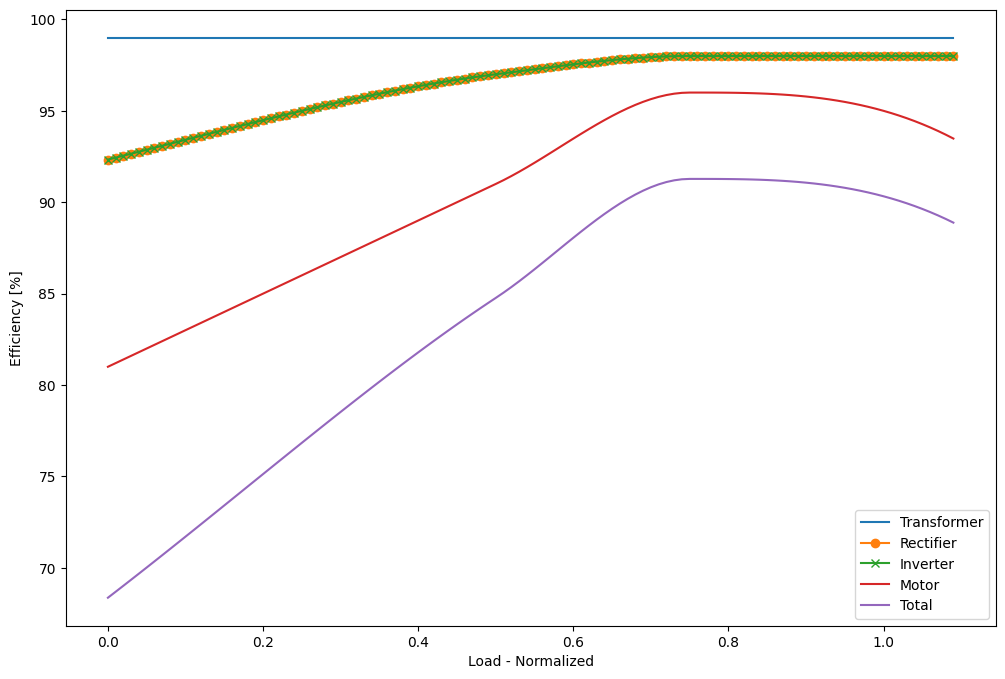

In [14]:
transformer_component = get_configured_component_from_name('Transformer 1', configuration_data)
transformer_component_data = get_component_data_from_name(transformer_component['component'], component_data)
transformer_1 = ElectricComponent(
    type_=get_type_component(transformer_component_data['type']),
    name=transformer_component['name'],
    rated_power=transformer_component_data['rated_power'],
    eff_curve=np.asarray(transformer_component_data['eff_curve']).transpose(),
    power_type=TypePower.POWER_TRANSMISSION,
    switchboard_id=transformer_component['switchboard_id'],
)

rectifier_component = get_configured_component_from_name('Rectifier 1', configuration_data)
rectifier_component_data = get_component_data_from_name(rectifier_component['component'], component_data)
rectifier_1 = ElectricComponent(
    type_=get_type_component(rectifier_component_data['type']),
    name=rectifier_component['name'],
    rated_power=rectifier_component_data['rated_power'],
    eff_curve=np.asarray(rectifier_component_data['eff_curve']).transpose(),
    power_type=TypePower.POWER_TRANSMISSION,
    switchboard_id=rectifier_component['switchboard_id'],
)

inverter_component = get_configured_component_from_name('Inverter 1', configuration_data)
inverter_component_data = get_component_data_from_name(inverter_component['component'], component_data)
inverter_1 = ElectricComponent(
    type_=get_type_component(inverter_component_data['type']),
    name=inverter_component['name'],
    rated_power=inverter_component_data['rated_power'],
    eff_curve=np.asarray(inverter_component_data['eff_curve']).transpose(),
    power_type=TypePower.POWER_TRANSMISSION,
    switchboard_id=inverter_component['switchboard_id'],
)

electric_motor_component = get_configured_component_from_name('Thruster motor 1', configuration_data)
electric_motor_component_data = get_component_data_from_name(electric_motor_component['component'], component_data)
thruster_motor_1 = ElectricMachine(
    type_=get_type_component(electric_motor_component_data['type']),
    name=electric_motor_component['name'],
    rated_power=electric_motor_component_data['rated_power'],
    rated_speed=electric_motor_component_data['rated_speed'],
    eff_curve=np.asarray(electric_motor_component_data['eff_curve']).transpose(),
    power_type=TypePower.POWER_CONSUMER,
    switchboard_id=electric_motor_component['switchboard_id'],
)

plt.figure(figsize=[12, 8])
load = np.arange(start=0.0, stop=1.1, step=0.01)
eff_transformer_1 = transformer_1.get_efficiency_from_load_percentage(load)
eff_rectifier_1 = rectifier_1.get_efficiency_from_load_percentage(load)
eff_inverter_1 = inverter_1.get_efficiency_from_load_percentage(load)
eff_thruster_motor_1 = thruster_motor_1.get_efficiency_from_load_percentage(load)
total_efficiency = eff_thruster_motor_1 * eff_rectifier_1 * eff_inverter_1 * eff_transformer_1
plt.plot(load, eff_transformer_1 * 100)
plt.plot(load, eff_rectifier_1 * 100, '-o')
plt.plot(load, eff_inverter_1 * 100, '-x')
plt.plot(load, eff_thruster_motor_1 * 100)
plt.plot(load, total_efficiency * 100)
plt.ylabel('Efficiency [%]')
plt.xlabel('Load - Normalized')
plt.legend(['Transformer', 'Rectifier', 'Inverter', 'Motor', 'Total'])

Now we can create a propulsion drive containing the four components

In [15]:
propulsion_drive_1 = SerialSystemElectric(
    type_=TypeComponent.PROPULSION_DRIVE,
    name="Propulsion drive 1",
    power_type=TypePower.POWER_CONSUMER,
    components=[transformer_1, rectifier_1, inverter_1, thruster_motor_1],
    rated_power=thruster_motor_1.rated_power,
    rated_speed=thruster_motor_1.rated_speed,
    switchboard_id=transformer_1.switchboard_id
)

Now we can calculate the power at the switchboard terminal (power_input) from the shaft power
of the motor (power_output)

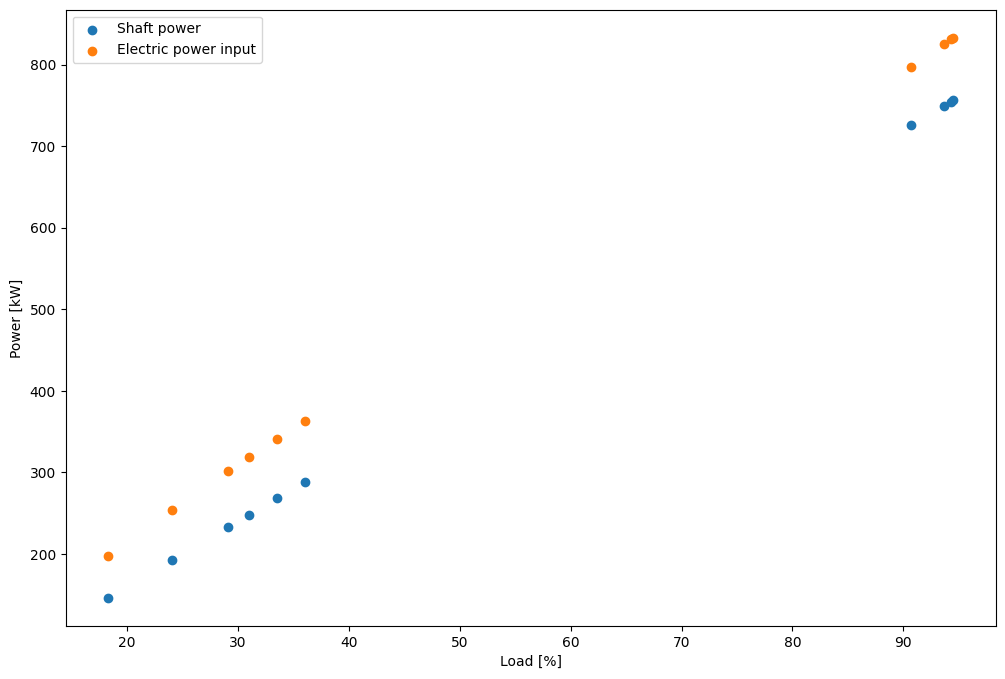

           El power [kW]  Shaft power[kW]  Efficiency [%]
18.293139     197.958448       146.345109       73.927186
24.038608     253.991421       192.308861       75.714707
29.139213     301.572323       233.113700       77.299435
31.027860     318.695525       248.222880       77.887156
33.505951     340.784837       268.047610       78.655967
36.099219     363.469630       288.793754       79.454714
90.661250     797.188107       725.290003       90.981037
93.644177     824.808935       749.153413       90.827509
94.316630     831.137450       754.533044       90.783184
94.503006     832.897347       756.024051       90.770376


In [16]:
power_output = propulsion_drive_1.rated_power * np.random.random(10)
power_input, load = propulsion_drive_1.set_power_input_from_output(power_output)
plt.figure(figsize=[12, 8])
plt.scatter(load*100, power_output)
plt.scatter(load*100, power_input)
plt.xlabel('Load [%]')
plt.ylabel('Power [kW]')
plt.legend(['Shaft power', 'Electric power input'])
plt.show()

data = np.array([power_input, power_output, power_output/power_input * 100]).transpose()
df = pd.DataFrame(data, index=load*100, columns=['El power [kW]', 'Shaft power[kW]', 'Efficiency [%]'])
df = df.sort_index()
print(df)

# Example 3: Create a system and perform power balance and fuel calculation
We will create components or serial components that are directly connected to the switchboard.

In [17]:
components = create_components_for_an_electric_system()
for component in components:
    print(component.name)
    print(component.switchboard_id)

Genset 1
1
Genset 2
2
Propulsion drive 1
1
Propulsion drive 2
2
Aux load
1


Now we can create an electric power system model.

In [ ]:
from feems.types_for_feems import TypePower
electric_power_system = ElectricPowerSystem(
    name='Power system',
    power_plant_components=components,
    bus_tie_connections=[(1,2)]
)
electric_power_system.__dict__

{'name': 'Power system',
 'power_sources': [<feems.components_model.component_electric.Genset at 0x12bd3f710>,
 'propulsion_drives': [<feems.components_model.component_electric.SerialSystemElectric at 0x12bf69160>,
 'pti_pto': [],
 'energy_storage': [],
 'other_load': [<feems.components_model.component_electric.ElectricComponent at 0x12bc02870>],
 'switchboards': {1: <feems.components_model.node.Switchboard at 0x12bf6b3b0>,
  2: <feems.components_model.node.Switchboard at 0x12bd86060>},
 'bus_tie_breakers': [<feems.components_model.node.BusBreaker at 0x12bd4d0a0>],
 'no_bus': [1],
 'switchboard2bus': [{1: 1, 2: 1}],
 'bus_tie_status_system': [array([ True])],
 'bus_configuration_change_index': [0],
 'switchboard_id': [1, 2],
 'no_bus_tie_breakers': 1,
 'no_power_sources': 2,
 'no_propulsion_units': 2,
 'no_energy_storage': 0,
 'no_pti_pto': 0,
 'no_other_load': 1,
 'no_switchboard': 2,
 'time_interval_s': [],
 'integration_method': <IntegrationMethod.simpson: 'simpson'>}

We can set power random power loads on the propulsion drives.

In [ ]:
number_points_load = 100
shaft_power_on_propulsion_drive_1 = \
    electric_power_system.propulsion_drives[0].rated_power * np.random.random(number_points_load)
shaft_power_on_propulsion_drive_2 = \
    electric_power_system.propulsion_drives[1].rated_power * np.random.random(number_points_load)
electric_power_system.set_power_input_from_power_output_by_switchboard_id_type_name(
    power_output=shaft_power_on_propulsion_drive_1,
    switchboard_id=1,
    type_=TypePower.POWER_CONSUMER,
    name="Propulsion drive 1"
)
electric_power_system.set_power_input_from_power_output_by_switchboard_id_type_name(
    power_output=shaft_power_on_propulsion_drive_2,
    switchboard_id=2,
    type_=TypePower.POWER_CONSUMER,
    name="Propulsion drive 2"
)
electric_power_system

Set a power load on the auxiliary load

In [20]:
auxiliary_load = 100 * np.random.random(number_points_load)
electric_power_system.set_power_input_from_power_output_by_switchboard_id_type_name(
    power_output=auxiliary_load,
    switchboard_id=1,
    type_=TypePower.POWER_CONSUMER,
    name="Aux load"
)

1

Now we need to set the status of the generators (on/off) and their load sharing mode.

In [21]:
electric_power_system.set_status_by_switchboard_id_power_type(
    switchboard_id=1,
    power_type=TypePower.POWER_SOURCE,
    status = np.ones([number_points_load, 1]).astype(bool) # <== No. 1 genset is on for all periods
)
electric_power_system.set_load_sharing_mode_power_sources_by_switchboard_id_power_type(
    switchboard_id=1,
    power_type=TypePower.POWER_SOURCE,
    load_sharing_mode=np.zeros([number_points_load, 1])  # <== Equal load sharing
)
electric_power_system.set_status_by_switchboard_id_power_type(
    switchboard_id=2,
    power_type=TypePower.POWER_SOURCE,
    status = np.ones([number_points_load, 1]).astype(bool) # <== No. 2 genset is on for all periods
)
electric_power_system.set_load_sharing_mode_power_sources_by_switchboard_id_power_type(
    switchboard_id=2,
    power_type=TypePower.POWER_SOURCE,
    load_sharing_mode=np.zeros([number_points_load, 1])  # <== Equal load sharing
)

Finally, bus-tie breaker status should be specified

In [22]:
status = np.ones([number_points_load, 1]).astype(bool)
status[int(number_points_load/2):,0] = False
electric_power_system.set_bus_tie_status_all(status)

Now we can do the power balance calculation which gives the power ouput of the gensets

In [ ]:
electric_power_system.set_time_interval(1, integration_method=IntegrationMethod.simpson)
electric_power_system.do_power_balance_calculation()

We will plot the power balance between the power consumers and sources

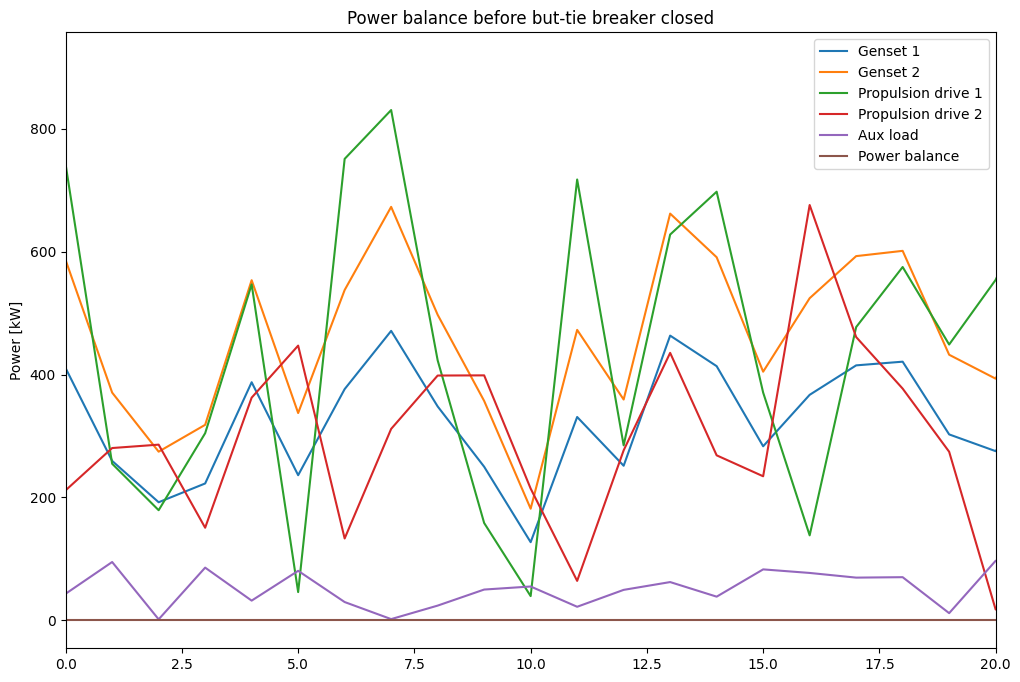

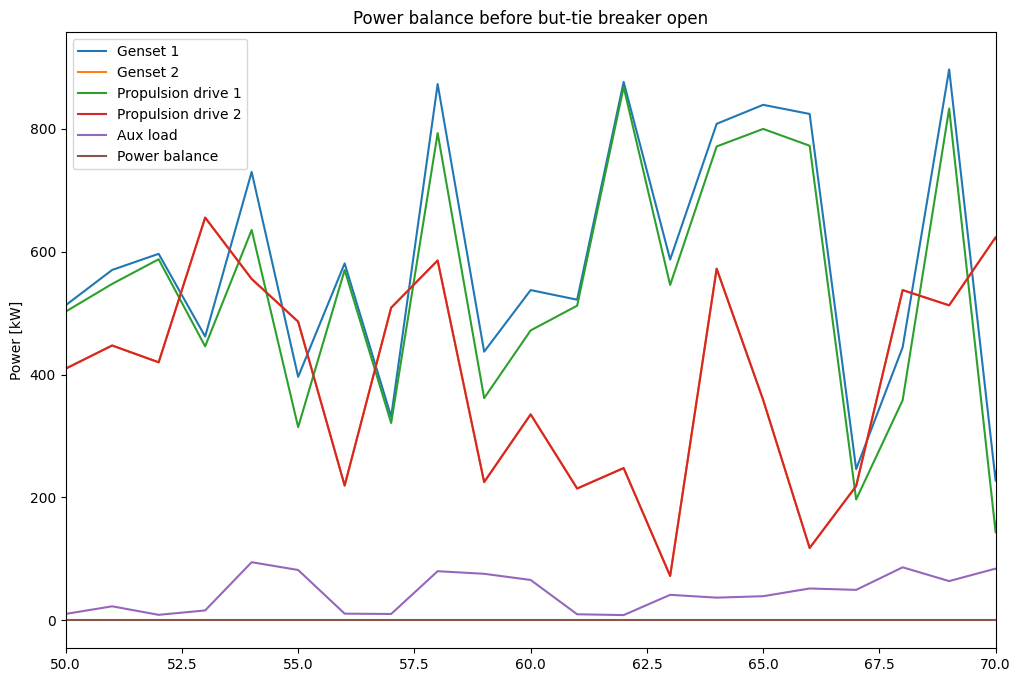

In [24]:
genset_1 = electric_power_system.power_sources[0]
genset_2 = electric_power_system.power_sources[1]
propulsion_drive_1 = electric_power_system.propulsion_drives[0]
propulsion_drive_2 = electric_power_system.propulsion_drives[1]
aux_load = electric_power_system.other_load[0]
power_balance = genset_1.power_output + genset_2.power_output - \
                propulsion_drive_1.power_input - propulsion_drive_2.power_input - aux_load.power_input

fig = plt.figure(figsize=[12, 8])
plt.plot(genset_1.power_output)
plt.plot(genset_2.power_output)
plt.plot(propulsion_drive_1.power_input)
plt.plot(propulsion_drive_2.power_input)
plt.plot(aux_load.power_input)
plt.plot(power_balance)
plt.ylabel('Power [kW]')
plt.xlim([0,20])
plt.title("Power balance before but-tie breaker closed")
plt.legend(['Genset 1', 'Genset 2', 'Propulsion drive 1', 'Propulsion drive 2', 'Aux load', 'Power balance'])

fig = plt.figure(figsize=[12, 8])
plt.plot(genset_1.power_output)
plt.plot(genset_2.power_output)
plt.plot(propulsion_drive_1.power_input)
plt.plot(propulsion_drive_2.power_input)
plt.plot(aux_load.power_input)
plt.plot(power_balance)
plt.ylabel('Power [kW]')
plt.xlim([50,70])
plt.title("Power balance before but-tie breaker open")
plt.legend(['Genset 1', 'Genset 2', 'Propulsion drive 1', 'Propulsion drive 2', 'Aux load', 'Power balance'])

Finally, we can calculate the fuel consumption and other KPIs

In [25]:
result = electric_power_system.get_fuel_energy_consumption_running_time()
result.__dict__

{'duration_s': 100,
 'energy_consumption_electric_total_mj': 0.0,
 'energy_consumption_mechanical_total_mj': 0.0,
 'energy_stored_total_mj': 0.0,
 'load_ratio_genset': None,
 'running_hours_main_engines_hr': 0.0,
 'running_hours_genset_total_hr': np.float64(0.05555555555555555),
 'running_hours_fuel_cell_total_hr': 0.0,
 'running_hours_pti_pto_total_hr': 0.0,
 'total_emission_kg': {<EmissionType.NOX: 2>: np.float64(0.21815404532992505)},
 'detail_result':                                 multi fuel consumption [kg]  \
 Genset 1  FuelConsumption(fuels=[<feems.fuel.Fuel object...   
 Genset 2  FuelConsumption(fuels=[<feems.fuel.Fuel object...   
 
          electric energy consumption [MJ] mechanical energy consumption [MJ]  \
 Genset 1                                0                           48.66619   
 Genset 2                                0                          47.299078   
 
          energy_stored [MJ] running hours [h]  \
 Genset 1                  0          0.027778   
 G

In [ ]:
# Save the system model to a protobuf file
import sys
import os
from MachSysS.convert_to_protobuf import convert_electric_system_to_protobuf_machinery_system

protobuf_file = os.path.join("data", "electric_power_system.pb")
electric_power_system_pb = convert_electric_system_to_protobuf_machinery_system(
    electric_power_system,
)

# Create the directory if it does not exist
os.makedirs(os.path.dirname(protobuf_file), exist_ok=True)

with open(protobuf_file, 'wb') as f:
    f.write(electric_power_system_pb.SerializeToString())


In [27]:
propulsion_drive_1.rated_power

800

In [28]:
propulsion_drive_2.rated_power

600